In [1]:
# from patch_CAVI import *
import numpy as np
import matplotlib.pyplot as plt
import torch
from types import SimpleNamespace
import sys
sys.path.append('..')
from field_of_junctions import FieldOfJunctions
import matplotlib
import cv2
from patch_CAVI_unary import *
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

## CAVI helpers

In [2]:
def func(x):
    x = -x.abs()
    mult = torch.exp(-30.0 * x.max(0, keepdim=True)[0].max(1, keepdim=True)[0] ** 2)
    return mult * 10.0 * torch.exp(3.0 * x)

## Creating simple FOJ patches

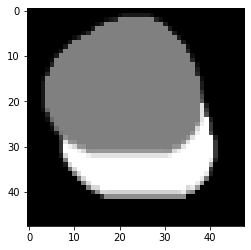

In [8]:
import numpy as np
import cv2


def perlin(x,y,seed=0):
    # permutation table
    #np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) # FIX1: I was using n10 instead of n01
    return lerp(x1,x2,v) # FIX2: I also had to reverse x1 and x2 here

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y


def get_curvature(rad):

    rad_t_plus_1  = np.concatenate([rad[1:], rad[:1]], axis=0)
    rad_t_minus_1 = np.concatenate([rad[-1:], rad[:-1]], axis=0)

    drad  = 0.5 * (rad_t_plus_1 - rad_t_minus_1) / (angle[1] - angle[0])
    d2rad = (rad_t_plus_1 - 2 * rad + rad_t_minus_1) / (angle[1] - angle[0]) ** 2

    curvature = np.abs(rad ** 2 + 2 * drad ** 2 - rad * d2rad) / np.sqrt((rad ** 2 + drad ** 2) ** 3)

    return curvature



H = W = 48
maxrad = H / 2.5
minrad = H / 4.0

RF = 21

num_imgs = 1

for i in range(num_imgs):

    img_np = np.zeros((H, W), dtype=np.uint8)
    edges = np.zeros((H, W), dtype=np.uint8)
    curvature_img = np.zeros((H, W), dtype=np.float32)
    junctions = np.ones((H, W), dtype=np.bool)

    axis_angle = np.random.rand() * 2 * np.pi

    colors = [255, 128] if np.random.rand() > 0.5 else [128, 255]
    for blob_id, clr in enumerate(colors):
        angle = np.linspace(0.0, 2*np.pi, 10001)[:-1]

        xp = 2.5 + 0.6 * np.cos(angle[np.newaxis, :])
        yp = 2.5 + 0.6 * np.sin(angle[np.newaxis, :])

        p = perlin(xp, yp)

        rad = minrad + (maxrad - minrad) * (0.5 + p)[0, :]

        
        xlist = rad * np.cos(angle) + 0.5 * H + 0.1 * H * np.cos(axis_angle + np.pi * (blob_id == 1))
        ylist = rad * np.sin(angle) + 0.5 * W + 0.1 * W * np.sin(axis_angle + np.pi * (blob_id == 1))

        pts = np.array([[int(x), int(y)] for (x, y) in zip(xlist, ylist)])
        pts = pts.reshape((1, -1, 2))

#         np.save(f'datasets/blobs_small/rad_{blob_id}_{i:03}.npy', rad)
#         np.save(f'datasets/blobs_small/pts_{blob_id}_{i:03}.npy', pts)
        
        
        curr_edges = np.zeros((H, W), dtype=np.uint8)
        cv2.fillPoly(img_np, pts, color=clr, lineType=cv2.LINE_AA)
        cv2.fillPoly(edges, pts, color=(0,))
        cv2.fillPoly(curr_edges, pts, color=(0,))
        cv2.fillPoly(curvature_img, pts, color=(0,))
        
        curvature = get_curvature(rad)
        for t in range(1000):
            clr = curvature[10*t:10*t+10].mean() / 0.02  # Not sure why 0.02, but that's the range
            cv2.polylines(curvature_img, pts[:, 10*t:10*t+10, :], False, (clr,), 1)
            cv2.polylines(curr_edges,    pts[:, 10*t:10*t+10, :], False, (255,), 1)
            cv2.polylines(edges,         pts[:, 10*t:10*t+10, :], False, (255,), 1)
            
        
        junctions &= (curr_edges > 128)


# img_np = cv2.resize(img_np, (55, 55), interpolation=cv2.INTER_AREA)
# edges = cv2.resize(edges, (55, 55), interpolation=cv2.INTER_AREA)
# junctions = cv2.resize(np.uint8(junctions) * 255, (55, 55), interpolation=cv2.INTER_AREA)
# curvature_img = cv2.resize(curvature_img, (55, 55), interpolation=cv2.INTER_AREA)

plt.imshow(img_np,cmap='gray')
img = img_np.reshape(img_np.shape[0],img_np.shape[1],1)
img = np.asarray(img/255.0,dtype=np.float32)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Beginning initialization...
Initialization iteration 0/30
Initialization iteration 5/30
Initialization iteration 10/30
Initialization iteration 15/30
Initialization iteration 20/30
Initialization iteration 25/30
Initialization done. Beginning refinement...
Refinement iteration 100/1000
Refinement iteration 200/1000
Refinement iteration 300/1000
Refinement iteration 400/1000
Refinement iteration 500/1000
Refinement iteration 600/1000
Refinement iteration 700/1000
Refinement iteration 800/1000
Refinement iteration 900/1000
Refinement iteration 1000/1000
CPU times: user 21min 6s, sys: 13min 13s, total: 34min 20s
Wall time: 7min 17s


NameError: name 'clean_img' is not defined

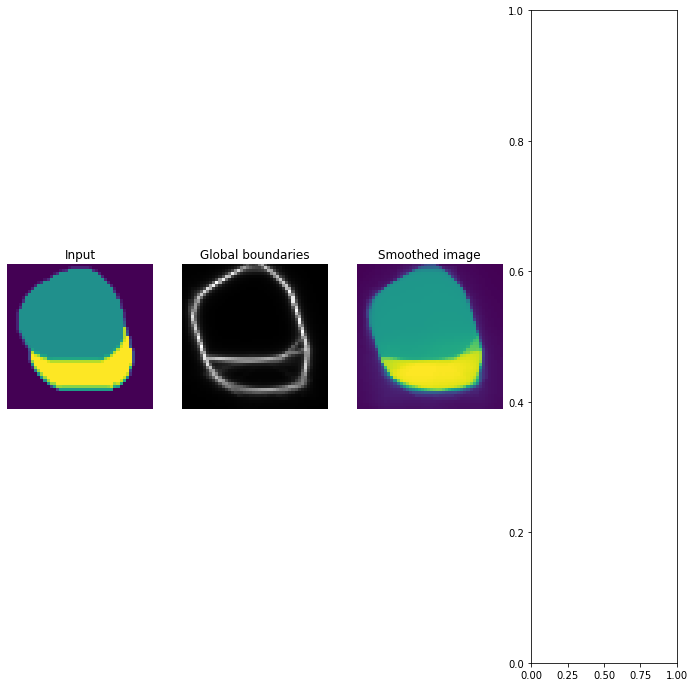

In [9]:
# Create opts object
opts = SimpleNamespace()

opts.R                        = 21
opts.stride                   = 1
opts.eta                      = 0.01
opts.delta                    = 0.05
opts.lr_angles                = 0.003
opts.lr_x0y0                  = 0.03
opts.lambda_boundary_final    = 0.5
opts.lambda_color_final       = 0.1
opts.nvals                    = 31
opts.num_initialization_iters = 30
opts.num_refinement_iters     = 1000
opts.greedy_step_every_iters  = 50
opts.parallel_mode            = True
opts.ang_per_vertex           = 3


# Define function for optimization (foj.optimize() may be used instead)
def foj_optimize_verbose():
    for i in range(foj.num_iters):
        if i == 0:
            print("Beginning initialization...")
        if i == opts.num_initialization_iters:
            print("Initialization done. Beginning refinement...")
        if i < opts.num_initialization_iters:
            if i % 5 == 0:
                print(f"Initialization iteration {i}/{opts.num_initialization_iters}")
        else:
            if i % 100 == 0:
                print(f"Refinement iteration {i}/{opts.num_refinement_iters}")
        foj.step(i)

# Create and optimize field of junctions
foj = FieldOfJunctions(img, opts)
%time foj_optimize_verbose()       # Run optimization with some printing

# Compute smoothed image and boundary map
params = torch.cat([foj.angles, foj.x0y0], dim=1)
dists, _, patches = foj.get_dists_and_patches(params)
local_boundaries = foj.dists2boundaries(dists)
global_boundaries = foj.local2global(local_boundaries)[0, 0, :, :].detach().cpu().numpy()
smoothed_img = foj.local2global(patches)[0, :, :, :].permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=[12, 12])
plt.subplot(141)
plt.imshow(img)
plt.title('Input')
plt.axis('off')
plt.subplot(142)
plt.imshow(global_boundaries, cmap='gray')
plt.title('Global boundaries')
plt.axis('off')
plt.subplot(143)
plt.imshow(smoothed_img)
plt.title('Smoothed image')
plt.axis('off')
plt.subplot(144)
plt.imshow(clean_img)
plt.title('Ground truth')
plt.axis('off');

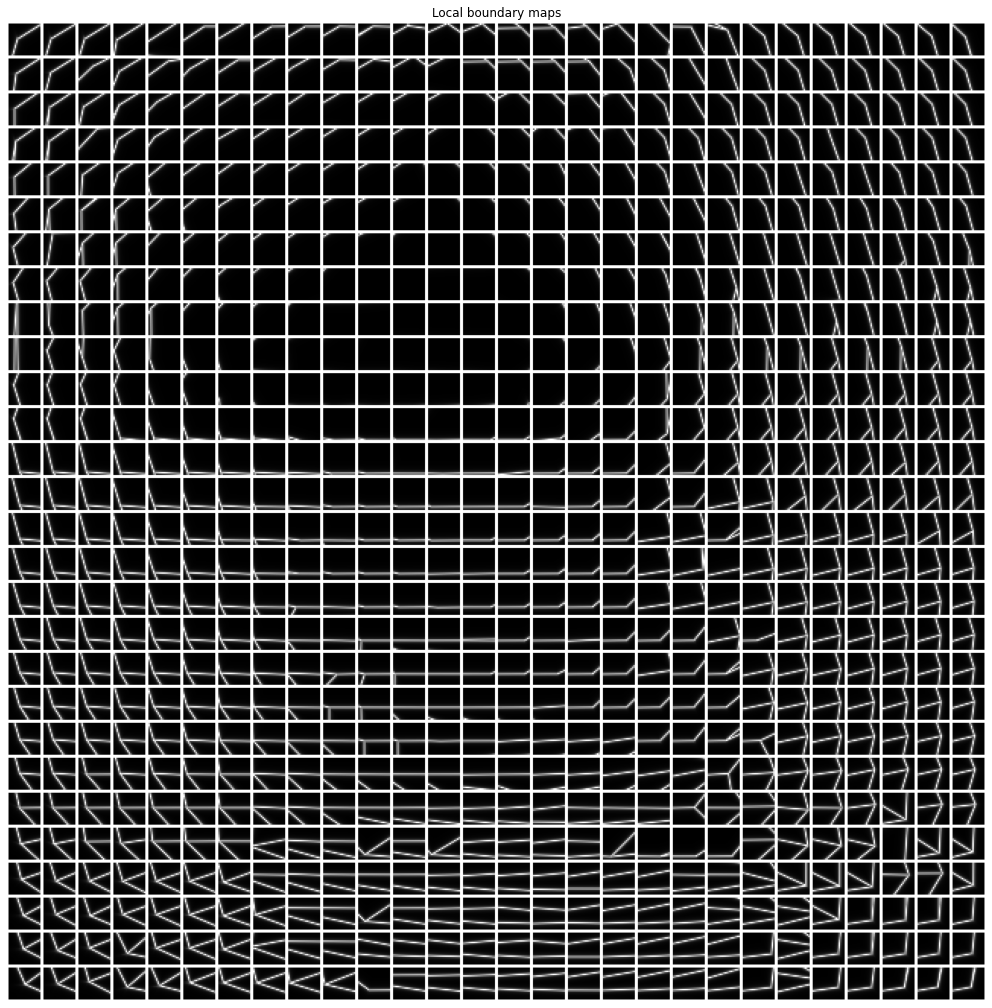

In [10]:
from utils import patchstack

boundary_vis = patchstack(local_boundaries)[0, :, :, :].detach().permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=[18, 18])
plt.imshow(boundary_vis, cmap='gray')
plt.title('Local boundary maps')
plt.axis('off');


In [11]:
angles = torch.remainder(params[:, :3, :, :], 2 * np.pi)
angles = torch.sort(angles, dim=1)[0].detach().cpu().numpy()

t_angle1 = angles[0, 0, :, :]   # shape [N, 1, 1, H', W']
t_angle2 = angles[0, 1, :, :]   # shape [N, 1, 1, H', W']
t_angle3 = angles[0, 2, :, :]  # shape [N, 1, 1, H', W']

#ANGLES ARE SWAPPED BECUASE WEDGES ORDERED COUNTERCLOCKWISE
angle1 = np.remainder(t_angle1-t_angle3,2*np.pi)
angle3 = np.remainder(t_angle2-t_angle1,2*np.pi) 
angle2 = np.remainder(t_angle3-t_angle2,2*np.pi)
anglemat = np.stack((angle1,angle2,angle3),axis = 0)

In [12]:
anglemat.shape

(3, 28, 28)

## Looking at initial wedges and ordering

Vertex position [[-0.08251752 -0.9067527 ]]
Original Angles [17.55029    8.9224205 18.993504 ]


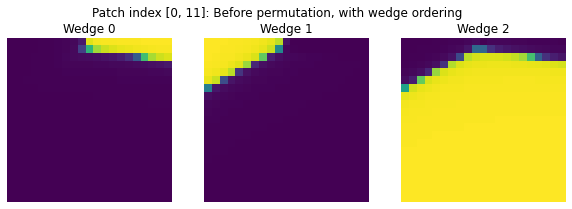

In [63]:
wedges = foj.dists2indicators(dists).detach().cpu().numpy()
# print('wedge shape', wedges.shape)
patch_index = [0,11]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: Before permutation, with wedge ordering')
plt.subplot(131)
plt.imshow(wedges[0,0,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(wedges[0,1,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(wedges[0,2,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)

angles = params[:, :3, :, :].detach().cpu().numpy()


print('Vertex position', params[:, 3:, patch_index[0],patch_index[1]].detach().cpu().numpy())


print('Original Angles', angles[0,:,patch_index[0],patch_index[1]])

# print('Wedge Angles', anglemat[:,patch_index[0],patch_index[1]])

# plt.colorbar()

# print('Wedge Range', np.min(wedges[0,1,:,:,0,0]),np.max(wedges[0,1,:,:,0,0]))

In [14]:
H_patches = wedges.shape[4]
W_patches = wedges.shape[5]
N=1

In [15]:
#Use wedges to create region patches, use these patches to create permutations

wedges = foj.dists2indicators(dists).detach().cpu()
region_patches = wedges.unsqueeze(1).unsqueeze(3)
permutations = get_permutations(region_patches)

In [16]:
idxs = resolve_permutations_mrf(permutations, stride=1, neighborhood=8, max_iters=None, func=func, func2=func, seed=[0,0])

In [17]:
idxs.shape

torch.Size([28, 28])

In [18]:
perm_list[idxs].shape

torch.Size([28, 28, 3])

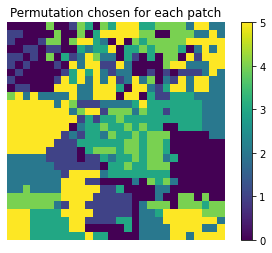

In [19]:
plt.imshow(idxs)
plt.axis('off')
plt.title('Permutation chosen for each patch')
plt.colorbar()
plt.show()

In [20]:
perm_tensor = perm_list[idxs].view(1,1,1,1,H_patches,W_patches,3)
perm_tensor = perm_tensor.repeat(1,1,opts.R,opts.R,1,1,1)
perm_tensor.shape 

torch.Size([1, 1, 21, 21, 28, 28, 3])

In [21]:
perm_list[idxs];

In [22]:
wedges = foj.dists2indicators(dists).detach().cpu()
perm_wedges = wedges.unsqueeze(-1).swapdims(1,6)

In [23]:
perm_wedges.shape

torch.Size([1, 1, 21, 21, 28, 28, 3])

In [24]:
sort_wedges = perm_wedges[0,0,:,:,idxs]

In [25]:
sort_wedges.shape

torch.Size([21, 21, 28, 28, 28, 3])

In [26]:
idxs.shape

torch.Size([28, 28])

In [27]:
test = torch.tensor([0,1,2]).view(1,1,-1).repeat(28,28,1)
test[perm_list[idxs]].shape

torch.Size([28, 28, 3, 28, 3])

In [28]:
sorted_wedges = torch.gather(perm_wedges, -1, perm_tensor)
sorted_wedges = sorted_wedges.swapdims(1,6).squeeze(-1)
sorted_wedges.shape

torch.Size([1, 3, 21, 21, 28, 28])

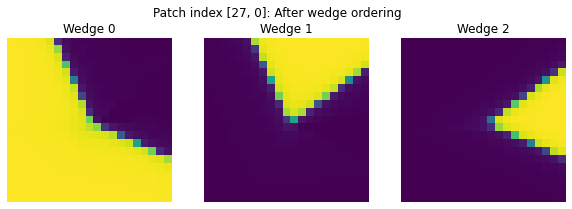

In [62]:

patch_index = [0,0]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: After wedge ordering')
plt.subplot(131)
plt.imshow(sorted_wedges[0,0,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(sorted_wedges[0,1,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(sorted_wedges[0,2,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)


In [30]:
sorted_angles = -1*torch.tensor(np.sort(-anglemat,axis=0))

## Next part: Sort by wedge size

In [31]:
ang_sort_idx = torch.tensor(np.argsort(-anglemat,axis=0))
# angles_ascending = np.take_along_axis(useful_angles, ang_sort_idx, axis=0)
ang_sort_idx = ang_sort_idx.unsqueeze(-1).swapdims(0,3).squeeze(0)
ang_sort_idx = ang_sort_idx.view(1,1,1,1,H_patches,W_patches,3)
ang_sort_idx = ang_sort_idx.repeat(1,1,opts.R,opts.R,1,1,1)
ang_sort_idx.shape

torch.Size([1, 1, 21, 21, 28, 28, 3])

In [32]:
ang_sorted_wedges_resh = torch.gather(perm_wedges, -1, ang_sort_idx)
ang_sorted_wedges = ang_sorted_wedges_resh.swapdims(1,6).squeeze(-1)


In [33]:
ang_region_patches = ang_sorted_wedges.unsqueeze(1).unsqueeze(3)
ang_permutations = get_permutations(ang_region_patches)

In [34]:
ang_idxs = resolve_permutations_mrf(ang_permutations, stride=1, neighborhood=8, max_iters=1000, func=func, func2=func, seed=[15,15])

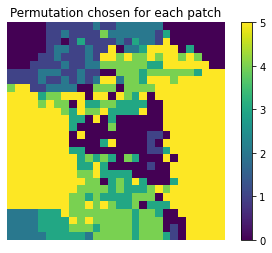

In [35]:
plt.imshow(ang_idxs)
plt.axis('off')
plt.title('Permutation chosen for each patch')
plt.colorbar()
plt.show()

In [36]:
ang_perm_tensor = perm_list[ang_idxs].view(1,1,1,1,H_patches,W_patches,3)
ang_perm_tensor = ang_perm_tensor.repeat(1,1,opts.R,opts.R,1,1,1)

ang_perm_wedges_resh = torch.gather(perm_wedges, -1, ang_perm_tensor)
ang_perm_wedges = ang_perm_wedges_resh.swapdims(1,6).squeeze(-1)



Vertex position [[-0.3061708   0.54592663]]
Wedge Angles tensor([3.3232, 1.9416, 1.0184])


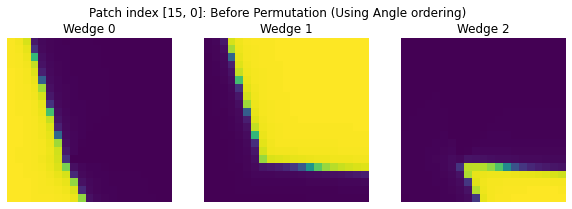

In [37]:
patch_index = [15,0]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: Before Permutation (Using Angle ordering)')
plt.subplot(131)
plt.imshow(ang_sorted_wedges[0,0,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(ang_sorted_wedges[0,1,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(ang_sorted_wedges[0,2,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)
print('Vertex position', params[:, 3:, patch_index[0],patch_index[1]].detach().cpu().numpy())
print('Wedge Angles', sorted_angles[:,patch_index[0],patch_index[1]])

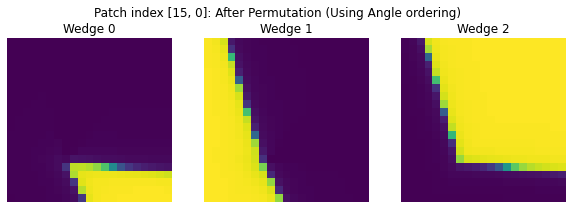

In [38]:
# patch_index = [23,27]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: After Permutation (Using Angle ordering)')
plt.subplot(131)
plt.imshow(ang_perm_wedges[0,0,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(ang_perm_wedges[0,1,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(ang_perm_wedges[0,2,:,:,patch_index[0],patch_index[1]])
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)


In [39]:
ang_idxs[patch_index[0],patch_index[1]]

tensor(5)

## Creating unary potentials

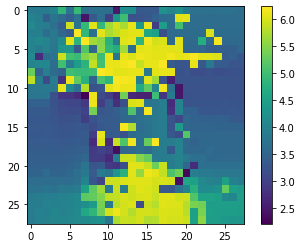

In [40]:
plt.imshow(sorted_angles[0,...].numpy())
plt.colorbar()

In [41]:
sorted_angles = -1*torch.tensor(np.sort(-anglemat,axis=0))
epsilon_0 = .3
epsilon_2 = .3

out_of_bounds = torch.max(torch.abs(foj.x0y0),axis=1)[0].squeeze(0) 
#Booleans representing the conditionals
w0_pi = torch.abs(sorted_angles[0,...]-torch.pi)<epsilon_0
w1_pi = torch.abs(sorted_angles[1,...]-torch.pi)<epsilon_0
w2_zero = sorted_angles[2,...]<epsilon_2

Text(0.5, 1.0, 'Case 3')

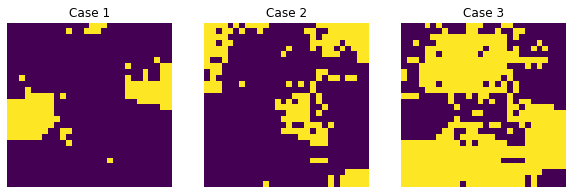

In [42]:
# plt.imshow(w0_pi.numpy())
# plt.imshow((out_of_bounds>1).numpy())
# plt.imshow(out_of_bounds.numpy())

# plt.imshow(w2_zero.numpy())
# torch.sum(w2_zero)


#Locations of Case 1 w0 -> pi, w2 !-> 0
plt.figure(figsize = [10,30])
plt.subplot(131)
plt.imshow(w0_pi.numpy()&  ~w2_zero.numpy()&(out_of_bounds<1).numpy())
plt.axis('off')
plt.title('Case 1')

#Locations of Case 2  w2 -> 0
plt.subplot(132)
plt.imshow(w2_zero.numpy() &~w1_pi.numpy()&(out_of_bounds<1).numpy())
plt.axis('off')
plt.title('Case 2')

#Locations of Case 3  w0 !-> pi, w2 !-> 0
plt.subplot(133)
plt.imshow((~w0_pi.numpy()& ~w2_zero.numpy())|(out_of_bounds>1).numpy())
plt.axis('off')
plt.title('Case 3')

In [43]:
unary_pots = np.zeros((6,*w2_zero.numpy().shape))
unary_pots[:,w0_pi.numpy()& ~w2_zero.numpy()] = np.array([[0,0,1,1,1,1]]).T
unary_pots[:,w2_zero.numpy()] = np.array([[0,0,0,1,1,1]]).T
unary_pots[:,~w0_pi.numpy()& ~w2_zero.numpy()] = np.array([[0,0,0,0,0,0]]).T

#Inverting
unary_pots = np.zeros((6,*w2_zero.numpy().shape)) 
unary_pots[:,w0_pi.numpy()& ~w2_zero.numpy()] = np.array([[1,1,0,0,0,0]]).T
unary_pots[:,w2_zero.numpy()&~w1_pi.numpy()] = np.array([[0,0,1,1,0,1]]).T
unary_pots[:,(~w0_pi.numpy()& ~w2_zero.numpy())|(out_of_bounds>1).numpy()] = np.array([[0,0,0,0,0,0]]).T

In [44]:
unary_pots.shape

(6, 28, 28)

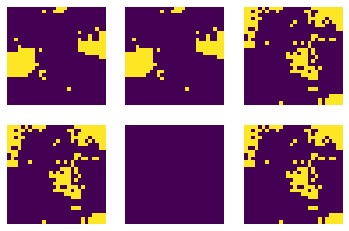

In [45]:
for itr in range(unary_pots.shape[0]):
    plt.subplot(2,3,itr+1)
    plt.imshow(unary_pots[itr,:,:])
    plt.axis('off')

In [57]:
ang_idxs_unary = resolve_permutations_mrf(ang_permutations, stride=1, neighborhood=8, max_iters=1000,unary = .1*unary_pots,  func=func, func2=func, seed=[15,0])

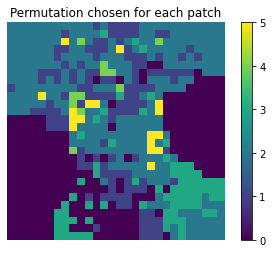

In [58]:
plt.imshow(ang_idxs_unary)
plt.axis('off')
plt.title('Permutation chosen for each patch')
plt.colorbar()
plt.show()

In [59]:
ang_perm_tensor_unary = perm_list[ang_idxs_unary].view(1,1,1,1,H_patches,W_patches,3)
ang_perm_tensor_unary = ang_perm_tensor_unary.repeat(1,1,opts.R,opts.R,1,1,1)

ang_perm_wedges_unary = torch.gather(ang_sorted_wedges_resh, -1, ang_perm_tensor_unary)
ang_perm_wedges_unary = ang_perm_wedges_unary.swapdims(1,6).squeeze(6)


In [60]:
ang_idxs_unary[16,0]
unary_pots[:,16,0]

array([1., 1., 0., 0., 0., 0.])

<ipython-input-61-07bb804dd9ee>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[10,30])


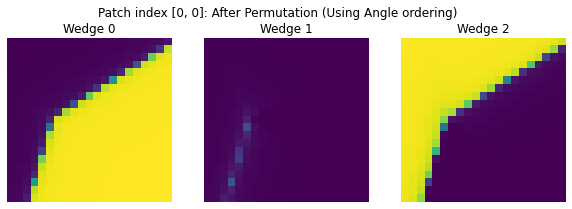

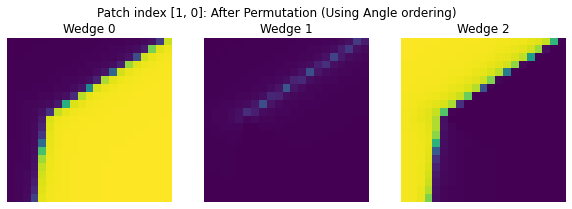

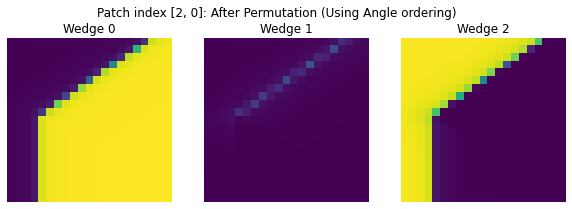

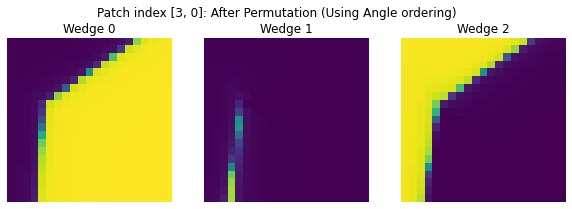

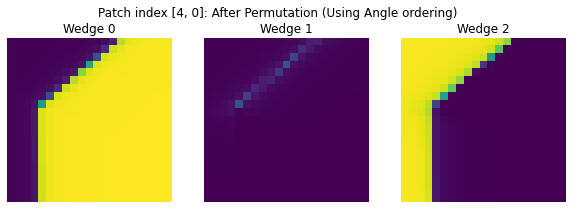

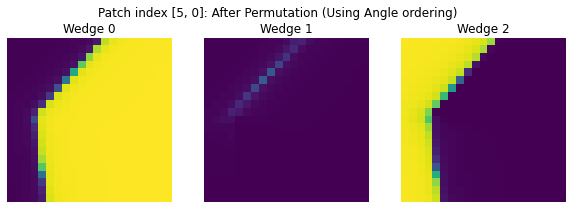

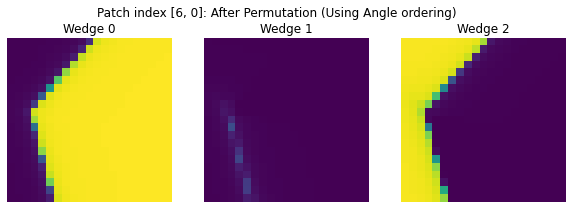

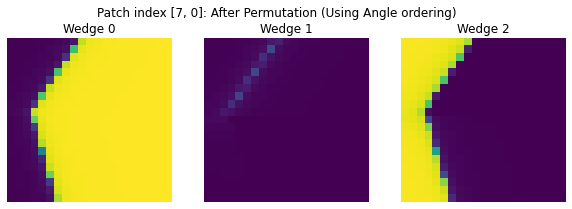

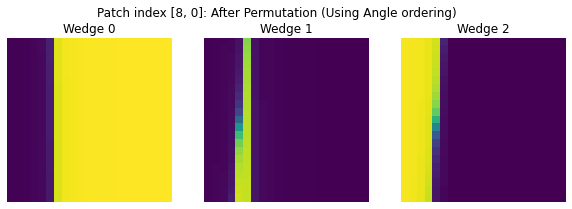

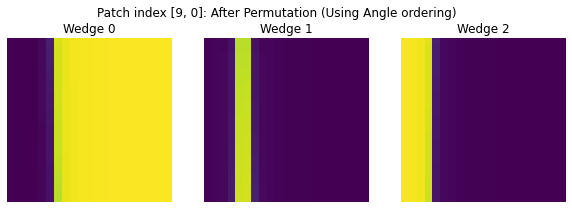

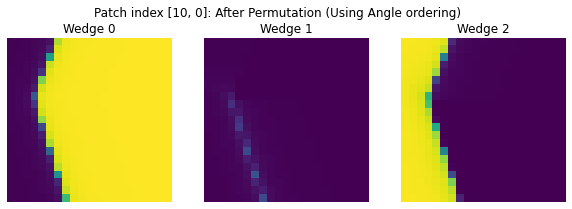

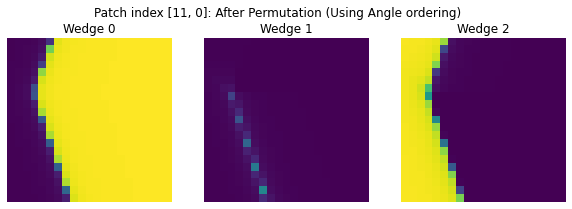

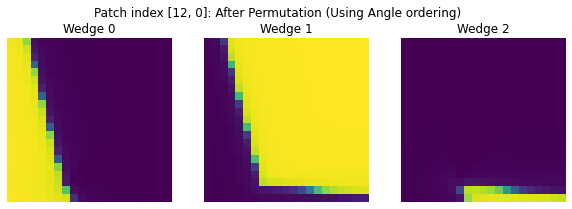

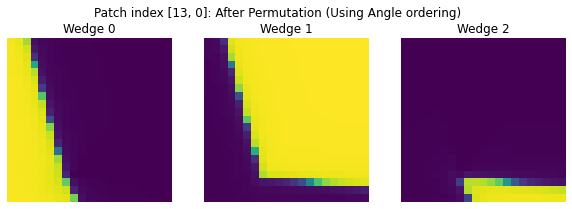

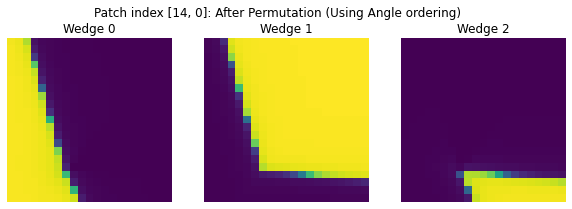

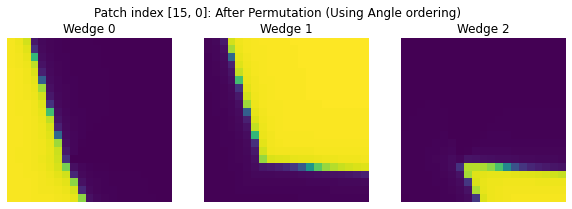

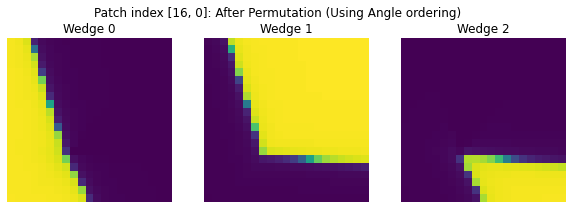

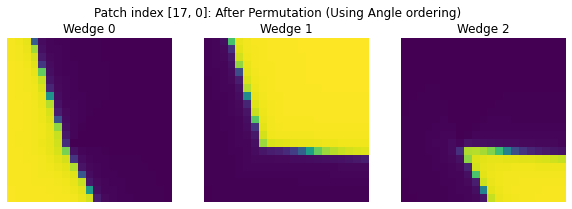

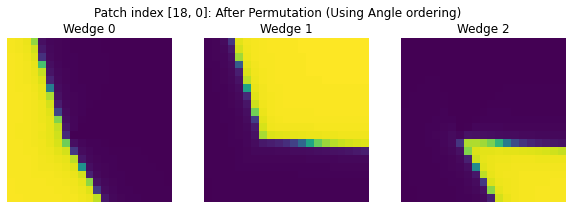

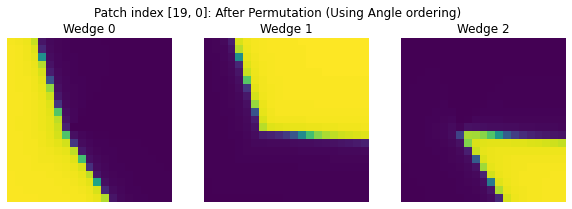

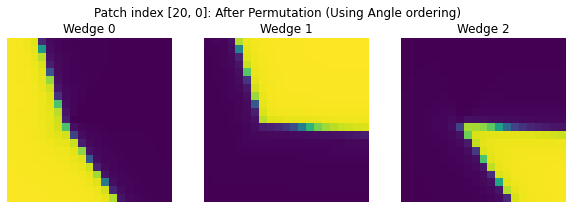

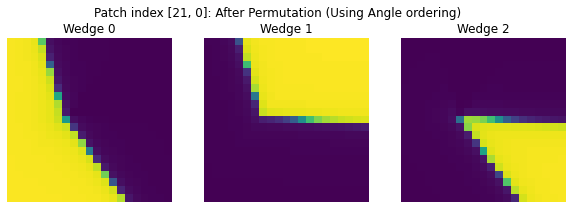

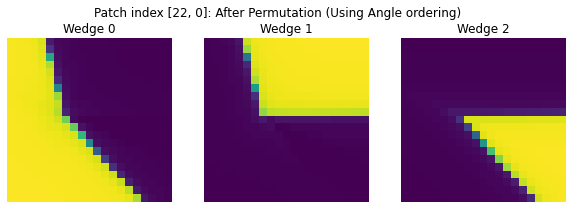

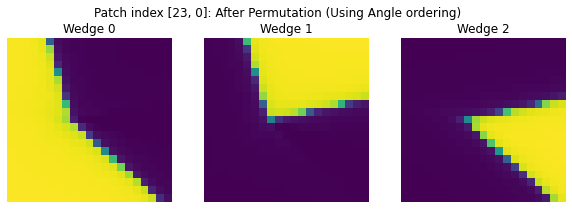

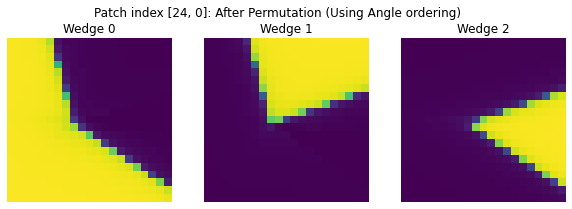

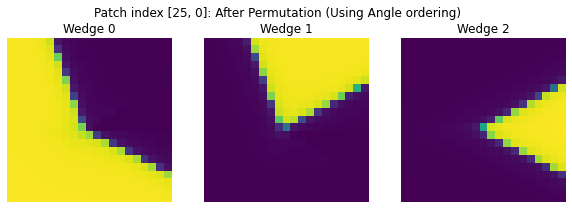

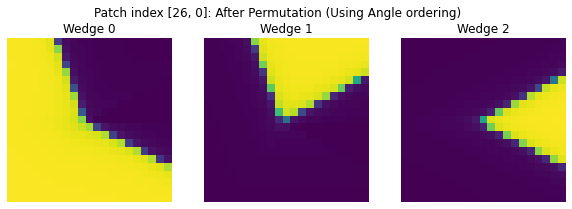

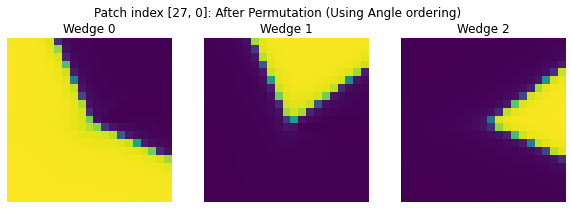

In [61]:
# @interactive
def plot_wedges(patch_idx_x =27, patch_idx_y = 0):
    patch_index = [patch_idx_x,patch_idx_y]
    plt.figure(figsize=[10,30])
    plt.suptitle(f'Patch index {patch_index}: After Permutation (Using Angle ordering)')
    plt.subplot(131)
    plt.imshow(ang_perm_wedges_unary[0,0,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
    plt.title('Wedge 0')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(ang_perm_wedges_unary[0,1,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
    plt.title('Wedge 1')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(ang_perm_wedges_unary[0,2,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
    plt.title('Wedge 2')
    plt.axis('off')
    plt.subplots_adjust(top=1.73)

for itr in range(28):
    plot_wedges(patch_idx_x =itr, patch_idx_y = 0)

In [51]:
def reconstruct_img(out,H,W,stride,PSZ):
    rec = np.zeros([H,W,int(out.shape[-2]*out.shape[-1])])
    num_overlaps = np.zeros([H,W])
    itr = 0
    for i in range(out.shape[-2]):
        for j in range(out.shape[-1]):
            rec[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ,itr] = out[...,i,j].detach().cpu().numpy()
            num_overlaps[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ] += 1
            itr = itr+1
    return np.divide(np.sum(rec,axis = -1),num_overlaps)


In [52]:
ang_perm_wedges_unary[0,0,...].shape

torch.Size([21, 21, 28, 28])

In [53]:
wedge_out_unary_1 = reconstruct_img(ang_perm_wedges_unary[0,0,...],48,48,opts.stride,opts.R)
wedge_out_1 =  reconstruct_img(ang_perm_wedges[0,0,...],48,48,opts.stride,opts.R)

Text(0.5, 1.0, 'Without Unary Potentials')

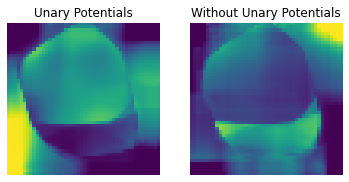

In [54]:
plt.subplot(121)
plt.imshow(wedge_out_unary_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Unary Potentials')
plt.subplot(122)
plt.imshow(wedge_out_1,vmin=0,vmax=1)
plt.axis('off')
plt.title('Without Unary Potentials')


Text(0.5, 1.0, 'Layer 3')

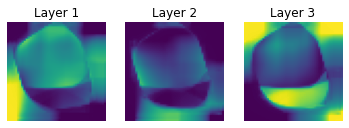

In [56]:
wedge_out_unary_1 = reconstruct_img(ang_perm_wedges_unary[0,0,...],48,48,opts.stride,opts.R)
wedge_out_unary_2 = reconstruct_img(ang_perm_wedges_unary[0,1,...],48,48,opts.stride,opts.R)
wedge_out_unary_3 = reconstruct_img(ang_perm_wedges_unary[0,2,...],48,48,opts.stride,opts.R)

plt.subplot(131)
plt.imshow(wedge_out_unary_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 1')
plt.subplot(132)
plt.imshow(wedge_out_unary_2,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 2')
plt.subplot(133)
plt.imshow(wedge_out_unary_3,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 3')